In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


import gensim.downloader
embed = gensim.downloader.load("glove-wiki-gigaword-100")

2023-10-28 16:52:47.275873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
path = os.getcwd()
base_directory = path + '/Data'

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
def method1(path, img_name):
    # load the image from file
    image = load_img(path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]

    # plt.imshow(image[0, ..., 0])
    # plt.axis('off')  # Turn off the axis
    # plt.title(image_id)
    # plt.show()
    # store feature
    return image_id, feature

In [4]:
def method2(path, img_name):
    target_height = 224
    target_width = 224
    # Load and preprocess image
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Calculate the aspect ratio of the original image
    original_height, original_width, _ = tf.unstack(tf.shape(image))
    aspect_ratio = tf.cast(original_width, tf.float32) / tf.cast(original_height, tf.float32)

    # Calculate the new dimensions while preserving the aspect ratio
    if aspect_ratio > 1.0:
        new_width = target_width
        new_height = tf.cast(target_width / aspect_ratio, tf.int32)
    else:
        new_height = target_height
        new_width = tf.cast(target_height * aspect_ratio, tf.int32)

    # Resize and pad the image to the target size
    resized_image = tf.image.resize_with_pad(image, target_height, target_width, method='bilinear')
    resized_image = tf.image.convert_image_dtype(resized_image, tf.uint8)
    resized_image = tf.expand_dims(resized_image, 0)

    image_id = img_name.split('.')[0]

    # plt.imshow(resized_image[0, ..., 0])
    # plt.axis('off')
    # plt.title(image_id)
    # plt.show()

    feature = model.predict(resized_image, verbose=0)
    return image_id, feature

In [ ]:
img_features = {}
working_directory = base_directory + '/images'

target_height = 224
target_width = 224
count = 0

for img_name in os.listdir(working_directory):
    if img_name.endswith('.jpg'):
        path = working_directory + '/' + img_name

        imid, fe = method1(path, img_name)
        # imid, fe = method2(path, img_name)
        img_features[imid] = fe
        count += 1
        if count % 100 == 0:
            print(count)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
# saving the features because processing the data takes a while
pickle.dump(img_features, open(os.path.join(base_directory, 'features.pkl'), 'wb'))

In [67]:
with open(os.path.join(base_directory, 'features2.pkl'), 'rb') as f:
    img_features = pickle.load(f)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
filename = base_directory + '/descriptions.csv'
captions = pd.read_csv(filename)
captions['file'] = captions['file'].str[:-4]
captions = captions[captions['file'] != 'a6a35734-ee74-42bd-a13a-dfa2b683fcda'] # outlier in length


In [68]:
# Create a dictionary to map labels to tokenized captions
mappings = {}

for index, row in captions.iterrows():
    label = row['file']
    tokens = row['description']
    mappings[label] = tokens
print(mappings['2d33d6a3-d2eb-496d-9ac6-832911e178f1'])


The student filled in two given sets of double number lines. In the first double number line, the student completed the top number line with "12\frac{1}{2}, 25, 37\frac{1}{2} , 50, 62\frac{1}{2} , 75, 87\frac{1}{2} , 100, 112\frac{1}{2} ". Note that 100 was pre-filled in the diagram. The student completed the bottom line with "2, 3, 4, 5, 6, 7, 8, 9". In the second double number line, the student completed the top number line with "40, 60, 80". The student completed the bottom number line with "1, 2, 3".



In [69]:
def clean_caption(caption):
    # Convert to lowercase
    caption = caption.lower()
    # Remove special characters and punctuation using regular expressions
    caption = re.sub(r'[^a-zA-Z\s]', '', caption)
    caption = ' '.join(caption.split())
    caption = 'startseq ' + caption + ' endseq'
    return caption

captions['description'] = captions['description'].apply(clean_caption)

In [70]:
# Initialize the tokenizer
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(captions['description'])
vocab_size = len(tokenizer.word_index) + 1

In [71]:
print("Vocab size: ", vocab_size)
max_length = max(len(caption.split()) for caption in captions['description'])
print("Max lenght: ", max_length)
max_length = 30

Vocab size:  1690
Max lenght:  180


In [72]:
# creating train-test split
image_ids = list(mappings.keys())
split = int(len(image_ids) * 0.9)
train = image_ids[:split]
test = image_ids[split:]

In [73]:
def data_generator(data_keys, mapping, features, tokenizer, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            caption = mapping[key]
            # encode the sequence
            seq = tokenizer.texts_to_sequences([caption])[0]
            # split the sequence into X, y pairs
            for i in range(1, len(seq)):
                # split into input and output pairs
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # store the sequences
                X1.append(features[key][0])
                X2.append(in_seq)
                y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [15]:
# Hyperparameters
lr = 0.001

In [74]:
embedding_matrix = np.zeros((vocab_size, embed.vectors.shape[1]))
for word, i in tokenizer.word_index.items():
    if word in embed:
        embedding_matrix[i] = embed[word]
print(embedding_matrix.shape)

(1690, 100)


In [75]:
# Create the model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
# Use GloVe embeddings for the embedding layer
se1 = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2023-10-28 18:16:47.413703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-28 18:16:47.418854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-28 18:16:47.423183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [76]:
def train_model():
    epochs = 15
    batch_size = 32
    steps = len(train) // batch_size

    for i in range(epochs):
        # create data generator
        generator = data_generator(train, mappings, img_features, tokenizer, batch_size)
        # fit for one epoch
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        print("Epoch ", i)

In [77]:
train_model()

2023-10-28 18:16:59.498196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-28 18:16:59.847837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-28 18:16:59.851148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

126/126 [==============================] - 64s 489ms/step - loss: 4.7899
Epoch  0


2023-10-28 18:18:03.950963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 63s 503ms/step - loss: 4.2471
Epoch  1


2023-10-28 18:19:07.535894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 67s 532ms/step - loss: 3.8463
Epoch  2


2023-10-28 18:20:14.786983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 65s 517ms/step - loss: 3.4873
Epoch  3


2023-10-28 18:21:20.210319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 65s 518ms/step - loss: 3.1865
Epoch  4


2023-10-28 18:22:25.756585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 65s 516ms/step - loss: 2.9280
Epoch  5


2023-10-28 18:23:31.012928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 65s 516ms/step - loss: 2.7053
Epoch  6


2023-10-28 18:24:36.282844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 66s 526ms/step - loss: 2.5088
Epoch  7


2023-10-28 18:25:42.803649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 65s 518ms/step - loss: 2.3583
Epoch  8


2023-10-28 18:26:48.244491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 189s 2s/step - loss: 2.2182
Epoch  9


2023-10-28 18:29:57.775651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 205s 2s/step - loss: 2.0776
Epoch  10


2023-10-28 18:33:22.600270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 700s 6s/step - loss: 1.9778
Epoch  11


2023-10-28 18:45:02.841730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 904s 7s/step - loss: 1.8726
Epoch  12


2023-10-28 19:00:06.657053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 642s 5s/step - loss: 1.7796
Epoch  13


2023-10-28 19:10:48.632797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 623s 5s/step - loss: 1.7153
Epoch  14


In [29]:
model.save(base_directory + '/best_model.h5')

In [84]:
# if I want to load a previous model
model = load_model(base_directory + '/best_model0.h5')

2023-10-28 21:20:44.669419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-28 21:20:44.675484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-28 21:20:44.680430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [85]:
# helper to generate captions
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [86]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        oov_ind = np.argmax(yhat)
        yhat[0, oov_ind] = 0
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        if word == 'UNK':
          continue
        # stop if word not found
        if word == None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [87]:
# if debugging
test = test[:25]

In [88]:
# validate with test data
actual, predicted = list(), list()

count = 0
for key in test:
    count += 1
    if count % 10 == 0:
      print(count)
    # get actual caption
    caption = mappings[key]
    # predict the caption for image
    y_pred = predict_caption(model, img_features[key], tokenizer, max_length)
    # split into words
    actual_caption = caption.split()
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_caption)
    predicted.append(y_pred)


ValueError: in user code:

    File "/Users/brad/env/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/Users/brad/env/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/brad/env/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/brad/env/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/Users/brad/env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/brad/env/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_8" is incompatible with the layer: expected shape=(None, 180), found shape=(None, 30)


In [81]:
from nltk.translate.bleu_score import corpus_bleu

# Print the average BLEU-1 score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

BLEU-1: 0.032649


In [82]:
from PIL import Image

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_directory, "images", image_name)
    image = Image.open(img_path)
    caption = mappings[image_id]
    print('---------------------Actual---------------------')
    print(caption)
    # predict the caption
    y_pred = predict_caption(model, img_features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
Polygon ABCD with a scaled copy polygon PQRS
Polygon ABCD has side length AB labeled 1 and side length AD labeled 2.
Polygon PQRS has side length PQ labeled 1.5 and side length PS labeled 3.

--------------------Predicted--------------------
startseq lines through side side labeled the right and the right and is labeled tale and the top number lines with a vertical lines through


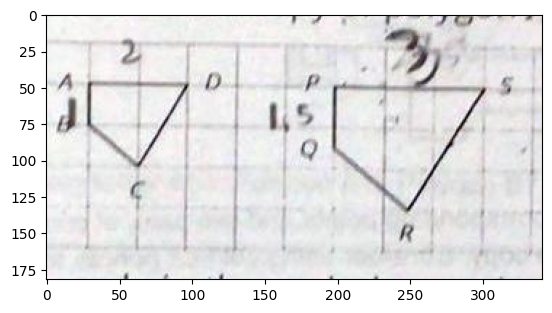

In [83]:
generate_caption('927edacd-9f8f-46fe-bcbf-1830ae7868c5.jpg')